## 状態空間モデルで時系列予測を行う（pystan）

In [1]:
%load_ext lab_black

In [2]:
# 必要なライブラリーのインポート
import numpy as np
import pandas as pd
from numpy.random import *
from scipy import stats
import pystan
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

# グラフを横長にする
from matplotlib import rcParams

rcParams["figure.figsize"] = 10, 6
sns.set()

# 表示する図表の設定
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 0.3
plt.rcParams["grid.color"] = "grey"
plt.rcParams["figure.figsize"] = (8, 4)

# 可視化に用いる色の設定
maincolor = "#70B145"

In [3]:
# データの読み込み
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv("../../data/AirPassengers.csv")

# float型に変換
# df['#Passengers'] = df['#Passengers'].astype('float64')
df = df.rename(columns={"#Passengers": "Passengers"})

# datetime型にしてインデックスにする
# df.Month = pd.to_datetime(df.Month)
# df = df.set_index("Month")

# データの中身を確認
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## ローカルレベルモデル

以下のローカルレベルモデルをStanでベイズ推定します。
\begin{align*}
y_t &= \mu_t + \epsilon_t, &\epsilon_t \sim N(0, \sigma_y^2) \\
\mu_t &= \mu_{t-1} + \eta_t,  &\eta_t \sim N(0, \sigma_{\mu}^2)
\end{align*}

In [4]:
local_level = """
data {
    int<lower=0> T; // number of learning points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t];
    }
}

model {
    for(t in 1:T) {
        Y[t] ~ normal(mu[t], s_y);
    }
    for(t in 2:T) {
        mu[t] ~ normal(mu[t-1], s_mu);
    }
}

generated quantities {
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        mu_pred[t] = normal_rng(mu_pred[t-1], s_mu);
        y_pred[t] = mu_pred[t];
    }
}
"""

In [5]:
stan_model = pystan.StanModel(model_code=local_level)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9bb0ebd023c1c9b55102b36db5240ae9 NOW.


In [6]:
y = df["Passengers"]
T = 137  # 学習期間
M = 7  # 予測期間

y_train = y[:-M]
y_test = y[-M:]

In [7]:
predict_dat = {"T": T, "M": M, "Y": y_train}

In [8]:
fit_local_level = stan_model.sampling(data=predict_dat, iter=4000, chains=4, seed=10)

In [9]:
print(fit_local_level)

Inference for Stan model: anon_model_9bb0ebd023c1c9b55102b36db5240ae9.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]        112.12    0.04    3.9 104.06 110.36 112.08 113.84 120.54  11848    1.0
mu[2]        118.06    0.03   3.92 109.91 116.22 118.02 119.86 126.31  13313    1.0
mu[3]        131.81    0.03   3.72 123.56 130.05 131.91 133.67 139.48  12008    1.0
mu[4]        128.88    0.03   3.91 120.39 127.08 128.94 130.75 137.03  12896    1.0
mu[5]        121.29    0.03   3.83 113.38 119.45 121.16 122.95 129.92  13761    1.0
mu[6]         135.0    0.03   3.83  127.0 133.19 134.97 136.75 143.43  14803    1.0
mu[7]        147.74    0.04   3.78 139.24 146.02 147.83  149.5 155.61  11153    1.0
mu[8]        147.76    0.03   3.78 139.25 145.99 147.87 149.54 155.74  12005    1.0
mu[9]        135.95    0.04   3.87 127.49 134.24 135.97

In [10]:
# サンプリング結果の抽出
ms_local_level = fit_local_level.extract()
y_pred = ms_local_level["y_pred"].mean(axis=0)

In [11]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level["y_pred"], q=quantile, axis=0).T
colname = ["p5", "p95"]
df_pred = pd.DataFrame(per_5_95, columns=colname)
df_pred

,p5,p95
0,106.016003,118.384050
1,111.716157,124.511498
2,125.587471,137.636097
3,122.478521,135.102052
4,115.543499,127.721717
...,...,...
139,383.307681,562.556918
140,369.751457,576.710152
141,357.159215,586.574427
142,346.791456,597.608946


In [12]:
# 予測値を追加
df_pred["y_pred"] = y_pred

In [13]:
mu_hat = ms_local_level["mu"].mean(axis=0)

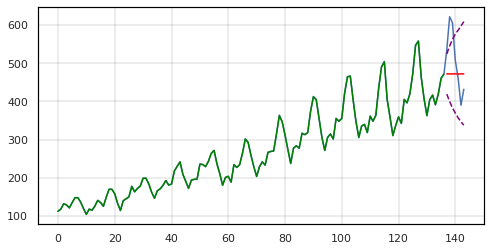

In [14]:
df.plot(y="Passengers", legend=False)  # 目的変数
plt.plot(df_pred[["p5", "p95"]][-7:], linestyle="dashed", color="purple")  # 予測区間
plt.plot(df_pred[["y_pred"]][-7:], color="red")  # 予測値
plt.plot(mu_hat, color="green")  # 状態
plt.show()

## ローカルレベルモデル(2階差分トレンド)

\begin{align*}
y_t &= \mu_t + \epsilon_t, \epsilon_t \sim N(0, \sigma_y^2) \\
\mu_t &= 2\mu_{t-1} - \mu_{t-2} + \eta_t,  \eta_t \sim N(0, \sigma_{\mu}^2)
\end{align*}

In [15]:
local_level_smooth = """
data {
    int<lower=0> T; // number of time points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t];
    }
}

model {
    for(t in 1:T) {
        Y[t] ~ normal(y_hat[t], s_y);
    }
    for(t in 3:T) {
        mu[t] ~ normal(2*mu[t-1] - mu[t-2], s_mu);
    }
}

generated quantities {
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        mu_pred[t] = normal_rng(2 * mu_pred[t-1] - mu_pred[t-2], s_mu);
        y_pred[t] = mu_pred[t];
    }
}
"""

In [16]:
stan_model = pystan.StanModel(model_code=local_level_smooth)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8e2075ff8b7d910b73b5adc01fd5ffb NOW.


In [17]:
fit_local_level_smooth = stan_model.sampling(
    data=predict_dat, iter=4000, chains=4, seed=10
)

In [18]:
print(fit_local_level_smooth)

Inference for Stan model: anon_model_f8e2075ff8b7d910b73b5adc01fd5ffb.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]        108.78    7.36   15.3  90.03  93.34 107.99  118.8 140.23      4   1.39
mu[2]        110.73    7.01   14.5  92.87  96.01 110.15 120.39 140.44      4   1.39
mu[3]        112.68    6.66  13.72  95.67  98.69 112.22 121.94 140.77      4    1.4
mu[4]        114.63    6.31  12.98  98.46 101.35 114.18 123.41 140.96      4    1.4
mu[5]        116.58    5.97  12.28 101.27  104.0 116.18 124.89 141.22      4   1.41
mu[6]        118.53    5.62   11.6 104.06 106.64 118.17 126.44 141.62      4    1.4
mu[7]        120.49    5.27  10.98 106.83 109.27 120.16 127.95 142.25      4    1.4
mu[8]        122.45    4.94  10.38 109.55  111.9 122.12 129.43  143.0      4   1.39
mu[9]        124.42    4.61   9.83  112.2 114.52 124.08

In [19]:
# サンプリング結果の抽出
ms_local_level_smooth = fit_local_level_smooth.extract()
y_pred = ms_local_level_smooth["y_pred"].mean(axis=0)

In [20]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level_smooth["y_pred"], q=quantile, axis=0).T
colname = ["p5", "p95"]
df_pred = pd.DataFrame(per_5_95, columns=colname)
df_pred

,p5,p95
0,90.839285,139.337498
1,93.567226,139.702388
2,96.321568,140.056312
3,99.057456,140.460724
4,101.771298,141.000831
...,...,...
139,435.053949,477.262607
140,436.577442,480.833945
141,438.007004,484.720930
142,439.119904,488.610231


In [21]:
# 予測値を追加
df_pred["y_pred"] = y_pred

In [22]:
mu_hat = ms_local_level_smooth["mu"].mean(axis=0)

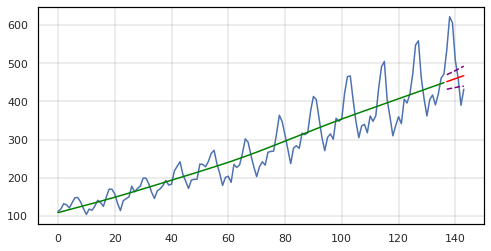

In [23]:
df.plot(y="Passengers", legend=False)  # 目的変数
plt.plot(df_pred[["p5", "p95"]][-7:], linestyle="dashed", color="purple")  # 予測区間
plt.plot(df_pred[["y_pred"]][-7:], color="red")  # 予測値
plt.plot(mu_hat, color="green")  # 状態
plt.show()

## ローカルレベルモデル+月別効果

\begin{align*}
y_t &= \mu_t + \gamma_t + \epsilon_t, &\epsilon_t \sim N(0, \sigma_y^2) \\
\mu_t &= 2\mu_{t-1} - \mu_{t-2} + \eta_t,  &\eta_t \sim N(0, \sigma_{\mu}^2)\\
\gamma_t &= -\sum_{l=1}^{11} \gamma_{t-l} + v_t, &v_t \sim N(0, \sigma_{\gamma}^2)
\end{align*}

In [24]:
local_level_smooth_season = """
data {
    int<lower=0> T; // number of time points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real month_eff[T]; // month effect
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
    real<lower=0> s_month; // sd of month effect
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t] + month_eff[t];
    }
}

model {
    for(t in 12:T) {
        month_eff[t] ~ normal(-sum(month_eff[(t-11):(t-1)]), s_month);
    }
    for(t in 1:T) {
        Y[t] ~ normal(y_hat[t], s_y);
    }
    for(t in 3:T) {
        mu[t] ~ normal((2 * mu[t-1] - mu[t-2]), s_mu);
    }
}

generated quantities {
    real month_eff_pred[T+M];
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        month_eff_pred[t] = month_eff[t];
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        month_eff_pred[t] = normal_rng(-sum(month_eff_pred[(t-11):(t-1)]), s_month);
        mu_pred[t] = normal_rng(2 * mu_pred[t-1] - mu_pred[t-2], s_mu);
        y_pred[t] = mu_pred[t] + month_eff_pred[t];
    }
}
"""

In [25]:
stan_model = pystan.StanModel(model_code=local_level_smooth_season)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_22e985e390df597b4876aed6d3598b93 NOW.


In [26]:
fit_local_level_smooth_season = stan_model.sampling(
    data=predict_dat, iter=4000, chains=4, seed=10
)

In [27]:
print(fit_local_level_smooth_season)

Inference for Stan model: anon_model_22e985e390df597b4876aed6d3598b93.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
month_eff[1]        -38.83    0.26    7.1 -52.49 -43.58 -38.88 -34.03 -24.91    731   1.01
month_eff[2]        -26.68    0.22    5.2 -37.01 -30.12 -26.63 -23.18 -16.67    542   1.01
month_eff[3]         -5.66     0.2   5.24 -16.06  -9.21   -5.6  -2.09   4.45    683   1.01
month_eff[4]          0.18     0.2   5.24 -10.53  -3.27   0.21   3.68  10.44    670   1.01
month_eff[5]          3.84     0.2    5.1  -6.19    0.4   3.86   7.25   14.2    639    1.0
month_eff[6]         30.25    0.22    5.1   20.7  26.73  30.12  33.67  40.52    542    1.0
month_eff[7]         50.14    0.25   5.33  39.86   46.5  50.04   53.7  60.77    461    1.0
month_eff[8]         47.02    0.23   5.29  37.05  43.35   47.0  50.51   57.8    552

In [28]:
# サンプリング結果の抽出
ms_local_level_smooth_season = fit_local_level_smooth_season.extract()
y_pred = ms_local_level_smooth_season["y_pred"].mean(axis=0)

In [29]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level["y_pred"], q=quantile, axis=0).T
colname = ["p5", "p95"]
df_pred = pd.DataFrame(per_5_95, columns=colname)
df_pred

,p5,p95
0,106.016003,118.384050
1,111.716157,124.511498
2,125.587471,137.636097
3,122.478521,135.102052
4,115.543499,127.721717
...,...,...
139,383.307681,562.556918
140,369.751457,576.710152
141,357.159215,586.574427
142,346.791456,597.608946


In [30]:
# 予測値を追加
df_pred["y_pred"] = y_pred

In [31]:
# 状態の推定値
mu_hat = ms_local_level_smooth_season["mu"].mean(axis=0)

# 月別効果
month_eff_hat = ms_local_level_smooth_season["month_eff"].mean(axis=0)

# 状態+月別効果
y_hat = ms_local_level_smooth_season["y_hat"].mean(axis=0)

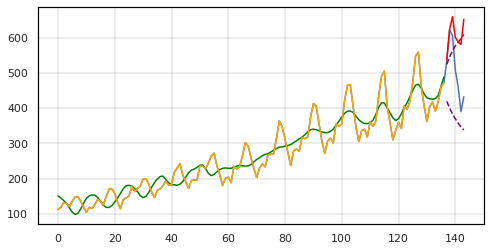

In [32]:
df.plot(y="Passengers", legend=False)  # 目的変数
plt.plot(df_pred[["p5", "p95"]][-7:], linestyle="dashed", color="purple")  # 予測区間
plt.plot(df_pred[["y_pred"]][-7:], color="red")  # 予測値
plt.plot(mu_hat, color="green")  # 状態
plt.plot(y_hat, color="orange")  # 状態+曜日効果
plt.show()

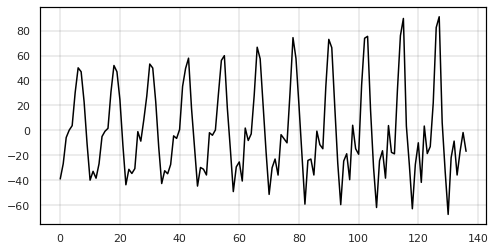

In [33]:
# 月別効果
plt.plot(month_eff_hat, color="black")